In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
from sklearn.metrics import confusion_matrix
from itertools import *
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


## Loading Data

Data was obtained from a [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats/data).

Let's organize the data into:
- Training Data
- Validation Data
- Testing Data

In [4]:
!ls

convolution_neural_animals.ipynb data


In [5]:
# change the directory to the dogs and cats directories
os.chdir('data/dogs-cats-data/')
# If the the train/dogs diretory does not exist then proceed to create some directories
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for e in random.sample(glob.glob('all_images/cat*'), 500):
        shutil.move(e,'train/cat')
    for e in random.sample(glob.glob('all_images/dog*'), 500):
        shutil.move(e,'train/dog')
    for e in random.sample(glob.glob('all_images/cat*'), 100):
        shutil.move(e,'valid/cat')
    for e in random.sample(glob.glob('all_images/dog*'), 100):
        shutil.move(e,'valid/dog')
    for e in random.sample(glob.glob('all_images/cat*'), 50):
        shutil.move(e,'test/cat')
    for e in random.sample(glob.glob('all_images/dog*'), 50):
        shutil.move(e,'test/dog')

In [6]:
os.chdir('../../')        

In [8]:
!ls

convolution_neural_animals.ipynb data


In [9]:
train_path = 'data/dogs-cats-data/train/'
valid_path = 'data/dogs-cats-data/valid/'
test_path = 'data/dogs-cats-data/test/'

In [10]:
# The images are passsed to the prerpocessing function before they get passed to the network
# target_size: it is the height and width of what we want the images to be resized to


train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = train_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10, shuffle = False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [12]:
imgs, labels = next(train_batches)

In [13]:
def plotImages(images_arr):
    """
    A function that plots images in the form of a grid with 1 row and 10 columns where images
    are placed according the preproceed VGG16 model.
    Returns a skewed RGB data of the images, and the One-Hot Encoding of the cats as 1s and Dogs
    as 0s
    """
    fig, axes = plt.subplots(1,10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

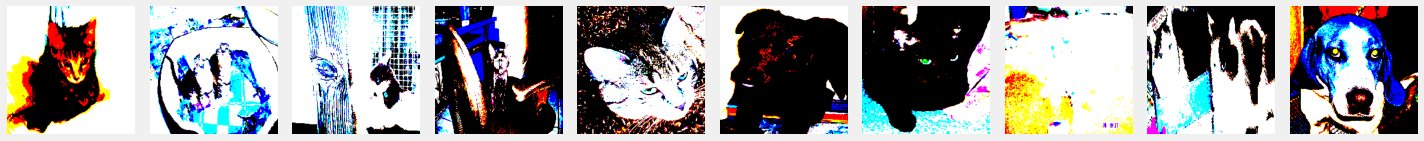

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [14]:
plotImages(imgs)
print(labels)

From the output we can still somewhat generalize and identify by eye which image belongs to cats and which one belongs to dogs.


However, if we take a look at the array of 1s and 0s, we can observe that is the [**One-Hot Encoder**](https://en.wikipedia.org/wiki/One-hot) of the classification of images. Representing the 1s as cats and the 0s as dogs. 

## Build and train a Convolution Neural Network

In [15]:
model = Sequential([
    Conv2D(filters = 32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation = 'softmax'),
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [17]:
model.compile(optimzer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches, validation_data = valid_batches, epochs=10, verbose=2)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 - 24s - loss: 63.4591 - accuracy: 0.5600 - val_loss: 0.6973 - val_accuracy: 0.5700
Epoch 2/10
100/100 - 22s - loss: 1.5262 - accuracy: 0.7750 - val_loss: 0.9764 - val_accuracy: 0.5950
Epoch 3/10
100/100 - 25s - loss: 1.3891 - accuracy: 0.8790 - val_loss: 1.7731 - val_accuracy: 0.6000
Epoch 4/10
100/100 - 28s - loss: 1.4556 - accuracy: 0.9170 - val_loss: 3.1533 - val_accuracy: 0.6100
Epoch 5/10
100/100 - 23s - loss: 3.6762 - accuracy: 0.9030 - val_loss: 6.1923 - val_accuracy: 0.6150
Epoch 6/10
100/100 - 23s - loss: 1.8336 - accuracy: 0.9540 - val_loss: 6.9559 - val_accuracy: 0.6600
Epoch 7/10
100/100 - 23s - loss: 1.5050 - accuracy: 0.9380 - val_loss: 20.7744 - val_accuracy: 0.5700
Epoch 8/10
100/100 - 24s - loss: 1.7437 - accuracy: 0.9360 - val_loss: 8.1243 - val_accuracy: 0.6550
Epoch 9/10
100/100 - 24s - loss: 1.8441 - accuracy: 0.9490 - val_loss: 12.8161 - val_accuracy: 0.6350
Epoch 10/10
100/100 - 24s - loss: 1.2846 - ac

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

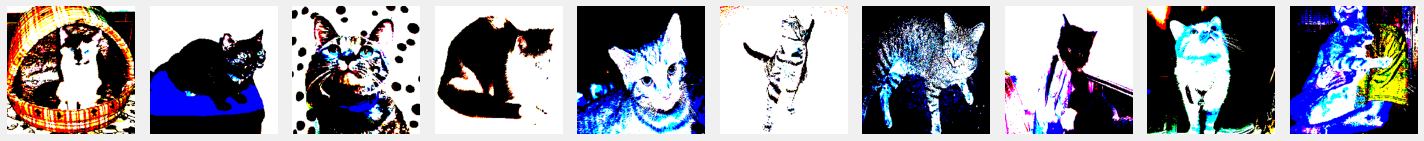

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [20]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [21]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [22]:
predictions = model.predict(x=test_batches, verbose=0)

In [23]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [24]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code Source: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[27 23]
 [ 8 42]]


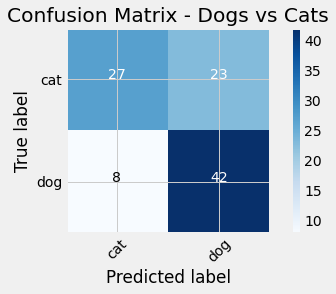

In [27]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title='Confusion Matrix - Dogs vs Cats')